In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dog-breed-identification.zip to dog-breed-identification.zip


In [ ]:
import zipfile
import os

zip_path = "dog-breed-identification.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dog-breed-identification")

data_dir = "dog-breed-identification"
print(os.listdir(data_dir))

['labels.csv', 'test', 'train', 'sample_submission.csv']


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
data_dir = "dog-breed-identification"
labels_df = pd.read_csv(os.path.join(data_dir, "labels.csv"))


breed_labels = labels_df['breed'].unique()
breed_to_idx = {breed: idx for idx, breed in enumerate(breed_labels)}
labels_df['label'] = labels_df['breed'].map(breed_to_idx)


In [ ]:
#資料切分
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42)



In [ ]:

class DogBreedDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['id']
        label = self.df.iloc[idx]['label']
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
#資料增強
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(15, translate=(0.1, 0.1)),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = DogBreedDataset(train_df, os.path.join(data_dir, "train"), transform=train_transform)
val_dataset = DogBreedDataset(val_df, os.path.join(data_dir, "train"), transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
#模型EfficientNetB0）
from torchvision.models import efficientnet_b0
model = efficientnet_b0(pretrained=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 150MB/s]


In [ ]:
# 解凍全部參數
for param in model.parameters():
    param.requires_grad = True

# 替換分類層
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(breed_labels))
model = model.to(device)


In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [ ]:
# 初始化變數
best_acc = 0.0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
y_true = []
y_pred = []

# 訓練迴圈
for epoch in range(20):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # 計算訓練準確率
    model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
    train_acc = train_correct / train_total
    train_accuracies.append(train_acc)

    # 驗證過程
    correct = 0
    total = 0
    val_running_loss = 0.0
    epoch_true = []
    epoch_pred = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch_true.extend(labels.cpu().numpy())
            epoch_pred.extend(predicted.cpu().numpy())

    val_loss = val_running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"儲存最佳模型（val_acc={val_acc:.4f}）")

    scheduler.step()

    print(f"Epoch {epoch+1}/20 - Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    y_true = epoch_true
    y_pred = epoch_pred


✅ 儲存最佳模型（val_acc=0.4856）
Epoch 1/20 - Train Loss: 4.1962, Train Acc: 0.3988, Val Loss: 2.7137, Val Acc: 0.4856
✅ 儲存最佳模型（val_acc=0.6719）
Epoch 2/20 - Train Loss: 2.6515, Train Acc: 0.5684, Val Loss: 1.4918, Val Acc: 0.6719
✅ 儲存最佳模型（val_acc=0.7213）
Epoch 3/20 - Train Loss: 1.9946, Train Acc: 0.6351, Val Loss: 1.1205, Val Acc: 0.7213
✅ 儲存最佳模型（val_acc=0.7462）
Epoch 4/20 - Train Loss: 1.7071, Train Acc: 0.6779, Val Loss: 0.9145, Val Acc: 0.7462
✅ 儲存最佳模型（val_acc=0.7653）
Epoch 5/20 - Train Loss: 1.5596, Train Acc: 0.6971, Val Loss: 0.8228, Val Acc: 0.7653
✅ 儲存最佳模型（val_acc=0.7790）
Epoch 6/20 - Train Loss: 1.4100, Train Acc: 0.7188, Val Loss: 0.7624, Val Acc: 0.7790
✅ 儲存最佳模型（val_acc=0.7873）
Epoch 7/20 - Train Loss: 1.3726, Train Acc: 0.7317, Val Loss: 0.7325, Val Acc: 0.7873
✅ 儲存最佳模型（val_acc=0.7927）
Epoch 8/20 - Train Loss: 1.3144, Train Acc: 0.7344, Val Loss: 0.7051, Val Acc: 0.7927
Epoch 9/20 - Train Loss: 1.2755, Train Acc: 0.7449, Val Loss: 0.7008, Val Acc: 0.7922
✅ 儲存最佳模型（val_acc=0.7971）
E

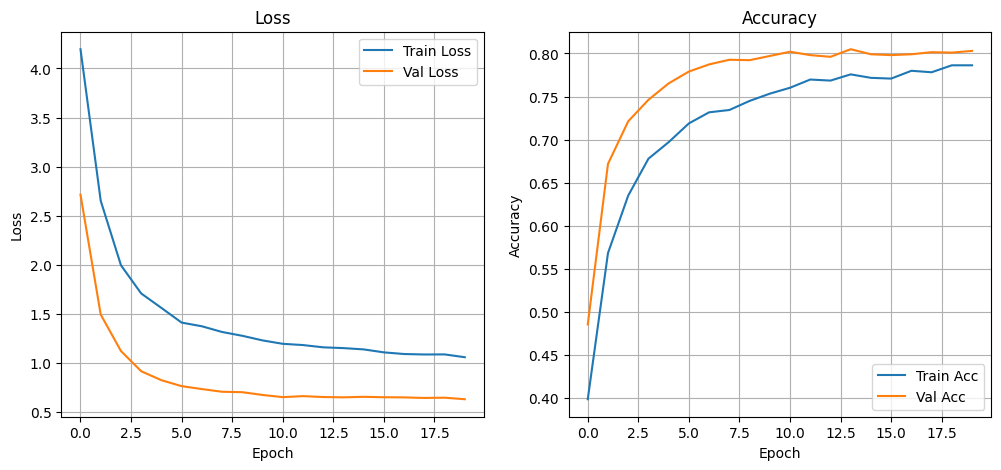

In [ ]:
plt.figure(figsize=(12, 5))

# Loss 圖
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy 圖
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

In [ ]:
#讀取test資料夾的檔案
test_dir = os.path.join(data_dir, "test")
test_files = os.listdir(test_dir)
test_files = [f for f in test_files if f.endswith(".jpg")]
test_ids = [os.path.splitext(f)[0] for f in test_files]

#
class TestDataset(Dataset):
    def __init__(self, file_list, img_dir, transform=None):
        self.file_list = file_list
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_id = self.file_list[idx]
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_id

test_dataset = TestDataset(test_ids, test_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === 載入最佳模型並進行預測 ===
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

submission = []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images)  # shape: (batch, 120)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()  # 轉成機率

        for img_id, prob in zip(ids, probs):
            row = [img_id] + prob.tolist()
            submission.append(row)

# === 儲存為 submission.csv ===
columns = ["id"] + list(breed_labels)
submission_df = pd.DataFrame(submission, columns=columns)
submission_df.to_csv("EfficientNetB0submission.csv", index=False)

print("已成功產生 submission.csv！")


✅ 已成功產生 submission.csv！


In [ ]:
from google.colab import files
files.download("EfficientNetB0submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>